# MPT with factor models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yfinance as yf

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [3]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(52/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(52) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    # volatility
    volatility = np.sqrt(52) * np.nanstd(rets)
    
    return total_return, apr, sharpe, maxDD, maxDDD, volatility

In [4]:
prices = pd.read_csv('sp500.csv', index_col=0)
returns = prices.pct_change().dropna()

# Baseline models

In [5]:
spy = yf.download('SPY', start='2018-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [6]:
spy_price = spy['Adj Close']
spy_ret = spy['Adj Close'].pct_change().dropna()

In [7]:
returns.index = spy_ret.index

In [8]:
returns

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.000043,0.006013,0.002211,0.015648,0.004615,-0.007733,0.018796,0.010863,-0.000919,0.002956,...,0.018709,-0.006279,-0.010834,-0.006693,0.012193,-0.000858,0.019863,0.006932,-0.001184,0.004598
2018-01-04,0.013071,0.004685,-0.001697,-0.005703,0.011841,0.016843,0.012042,0.009552,-0.003680,0.010314,...,0.010151,0.007813,0.005415,-0.007791,0.006677,0.010180,0.019760,-0.001441,0.004147,0.005964
2018-01-05,0.007792,0.012864,0.002890,0.017408,0.008249,-0.006675,0.011571,-0.000591,0.003693,0.006619,...,0.006413,0.009277,0.006671,-0.007003,-0.001874,0.005828,0.015576,0.009941,0.000394,0.011444
2018-01-08,-0.003242,0.004763,-0.002882,-0.016022,0.007991,-0.002240,-0.001619,-0.003043,0.000000,0.002563,...,-0.005387,0.000000,-0.013314,0.007480,0.003611,0.001690,0.009951,0.001905,-0.004915,0.011995
2018-01-09,0.006214,-0.000790,0.001700,0.007538,0.003335,0.003243,0.008971,0.006953,-0.010119,0.000445,...,0.002774,-0.004029,0.006778,-0.011667,0.000288,-0.002651,0.030643,-0.016083,0.023508,0.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.011925,0.011915,0.001388,-0.001041,0.005023,0.012087,0.005735,0.007443,0.013070,0.011846,...,0.008626,0.006644,-0.006401,0.012852,-0.000728,0.000621,0.002869,0.001106,0.003521,0.005034
2022-12-27,0.000666,0.013533,0.003605,-0.000674,-0.002931,0.013633,-0.009928,0.000374,0.004881,0.006829,...,0.000778,0.000407,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156
2022-12-28,-0.016054,-0.015606,-0.006816,-0.004663,-0.008255,-0.023877,-0.020174,-0.013193,-0.017349,-0.010659,...,-0.011612,-0.014629,-0.050279,-0.007203,-0.016077,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117


In [9]:
# prepare weekly data
prices.index = pd.to_datetime(prices.index)
prices_w = prices.resample('1W').last()
returns_w = prices_w.pct_change().dropna()
spy_price_w = spy_price.resample('1W').last()
spy_ret_w = spy_price_w.pct_change().dropna()

In [10]:
# calculate cumulative returns
cumret_eqw = (1 + returns_w.loc['2019-01-01':].sum(axis=1)/returns.shape[1]).cumprod()
cumret_spy = (1 + spy_ret_w.loc['2019-01-01':]).cumprod()

In [11]:
# calculate performance metrics
results_df = pd.DataFrame(columns = ['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD', 'Volatility'])
results_df.loc['SPY'] = calculate_metrics(cumret_spy)
results_df.loc['Equally Weighted'] = calculate_metrics(cumret_eqw)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD,Volatility
SPY,0.619579,0.127457,0.675479,-0.318290,52.0,0.211137
Equally Weighted,0.933575,0.178278,0.799373,-0.367922,52.0,0.242669


In [12]:
returns.cov()

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,0.000292,0.000186,0.000145,0.000121,0.000174,0.000152,0.000149,0.000174,0.000150,0.000173,...,0.000134,0.000190,0.000225,0.000096,0.000223,0.000135,0.000218,0.000161,0.000205,0.000137
AOS,0.000186,0.000360,0.000133,0.000101,0.000173,0.000145,0.000174,0.000170,0.000168,0.000172,...,0.000134,0.000200,0.000279,0.000084,0.000236,0.000124,0.000253,0.000145,0.000226,0.000141
ABT,0.000145,0.000133,0.000285,0.000144,0.000190,0.000123,0.000219,0.000179,0.000135,0.000137,...,0.000146,0.000163,0.000146,0.000124,0.000180,0.000129,0.000208,0.000158,0.000134,0.000195
ABBV,0.000121,0.000101,0.000144,0.000325,0.000143,0.000109,0.000148,0.000137,0.000120,0.000133,...,0.000107,0.000111,0.000144,0.000083,0.000127,0.000095,0.000141,0.000136,0.000131,0.000143
ACN,0.000174,0.000173,0.000190,0.000143,0.000323,0.000161,0.000277,0.000235,0.000221,0.000188,...,0.000188,0.000181,0.000262,0.000124,0.000230,0.000171,0.000276,0.000205,0.000213,0.000213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.000135,0.000124,0.000129,0.000095,0.000171,0.000130,0.000154,0.000167,0.000176,0.000186,...,0.000149,0.000148,0.000255,0.000108,0.000174,0.000277,0.000175,0.000181,0.000160,0.000162
ZBRA,0.000218,0.000253,0.000208,0.000141,0.000276,0.000187,0.000349,0.000243,0.000249,0.000210,...,0.000183,0.000227,0.000366,0.000104,0.000274,0.000175,0.000675,0.000211,0.000265,0.000240
ZBH,0.000161,0.000145,0.000158,0.000136,0.000205,0.000155,0.000181,0.000181,0.000233,0.000221,...,0.000158,0.000152,0.000349,0.000095,0.000202,0.000181,0.000211,0.000401,0.000247,0.000171
ZION,0.000205,0.000226,0.000134,0.000131,0.000213,0.000229,0.000142,0.000204,0.000261,0.000313,...,0.000177,0.000212,0.000456,0.000091,0.000269,0.000160,0.000265,0.000247,0.000597,0.000133


# MPT with sample covariance matrix

In [13]:
# find minimum variance portfolio
from scipy.optimize import minimize

# function to minimize
def volatility(weights, returns_covariance):
    return np.sqrt(weights.T @ returns_covariance @ weights * 252)

def negative_annual_return(weights, returns_mean):
    ret = weights.T @ returns_mean * 252
    return -ret

stocks = returns.columns

# initial guess
x0 = np.ones(len(stocks)) / len(stocks)

# bounds
bounds=[[0,1]]*len(stocks)

In [14]:
volatility_eqw = results_df.loc['Equally Weighted']['Volatility']

In [15]:
positions = pd.DataFrame(index=returns_w.loc['2019-01-01':].index, columns=returns_w.columns)

target_vol = volatility_eqw
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    
    # perform optimization
    constraints = ({'type':'eq', 'fun': lambda x: volatility(x,returns_tmp.cov())-target_vol}, 
                   {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    res = minimize(negative_annual_return, x0, args=(returns_tmp.mean()), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [1:12:47<00:00, 20.90s/it]


In [16]:
cumret_sample_cov = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()
results_df.loc['MPT (sample cov)'] = calculate_metrics(cumret_sample_cov)

In [17]:
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD,Volatility
SPY,0.619579,0.127457,0.675479,-0.318290,52.0,0.211137
Equally Weighted,0.933575,0.178278,0.799373,-0.367922,52.0,0.242669
MPT (sample cov),1.130718,0.207087,0.780375,-0.376376,59.0,0.301853


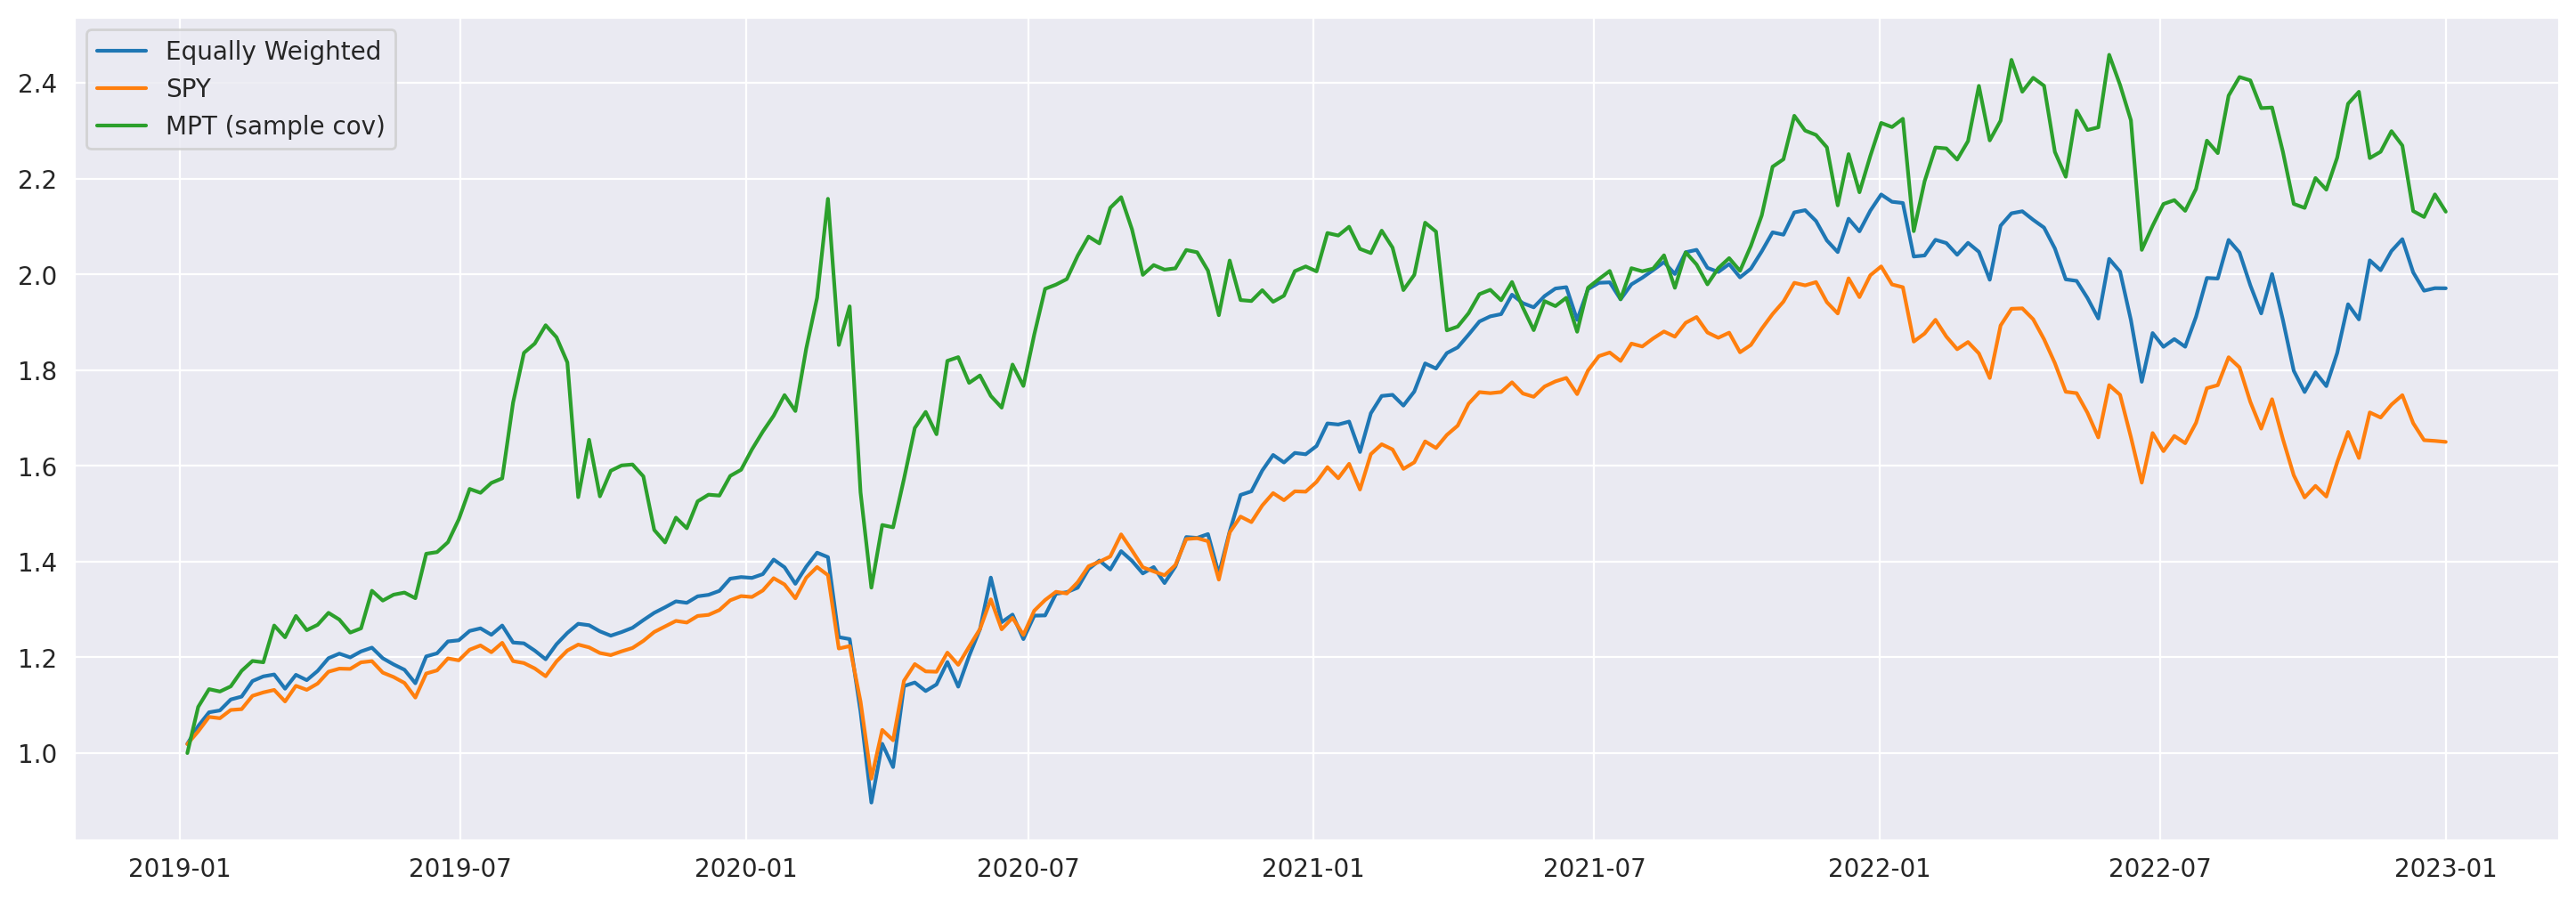

In [18]:
plt.figure(figsize=(18,6))
plt.plot(cumret_eqw, label='Equally Weighted')
plt.plot(cumret_spy, label='SPY')
plt.plot(cumret_sample_cov, label='MPT (sample cov)')
plt.legend()

# Single-index model

In [19]:
factors_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=4, index_col=0).iloc[:-1]
factors_df.index = pd.to_datetime(factors_df.index)
factors_df = factors_df.loc[returns.index] # keep only relevant dates
factors_df /= 100 # percentage to decimal
returns_rf = returns - factors_df['RF'].values.reshape(-1,1) # returns minus risk-free rate
mkt_rf = factors_df[['Mkt-RF']] # market return minus risk-free rate

In [20]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

metrics_df = pd.DataFrame(columns=['alpha', 'beta', 'alpha_pval', 'beta_pval', 'R_sq', 'Durbin-Watson', 'JB pval'])

for stock in tqdm(returns_rf.columns):
    res = sm.OLS(returns_rf[stock].values, sm.add_constant(mkt_rf.values)).fit() # fit a model
    metrics_df.loc[stock] = [*res.params, *res.pvalues, res.rsquared, sms.durbin_watson(res.resid), sms.jarque_bera(res.resid)[1]] # save metrics

100%|██████████| 490/490 [00:01<00:00, 294.49it/s]


In [21]:
metrics_df

,alpha,beta,alpha_pval,beta_pval,R_sq,Durbin-Watson,JB pval
MMM,-0.000597,0.785349,0.104445,2.973116e-150,0.418937,2.043695,0.000000e+00
AOS,-0.000166,0.829262,0.694165,3.034558e-132,0.379323,2.035066,2.526723e-185
ABT,0.000347,0.828250,0.314296,3.354905e-179,0.477395,1.985795,0.000000e+00
ABBV,0.000454,0.645919,0.301110,2.574274e-82,0.254868,1.921901,0.000000e+00
ACN,0.000212,1.058302,0.454535,1.047419e-320,0.688848,2.106587,0.000000e+00
...,...,...,...,...,...,...,...
YUM,0.000233,0.760548,0.517074,2.256190e-148,0.414921,2.027680,0.000000e+00
ZBRA,0.000527,1.282428,0.317109,1.338832e-182,0.483862,2.145673,0.000000e+00
ZBH,-0.000109,0.898467,0.803970,4.095797e-141,0.399159,2.233679,0.000000e+00
ZION,-0.000061,1.047937,0.911518,4.441776e-126,0.365151,2.034666,0.000000e+00


In [22]:
metrics_df.describe()

,alpha,beta,alpha_pval,beta_pval,R_sq,Durbin-Watson,JB pval
count,490.000000,490.000000,490.000000,4.900000e+02,490.000000,490.000000,4.900000e+02
mean,0.000195,0.982062,0.548838,7.838378e-17,0.395408,2.005821,5.931933e-28
std,0.000428,0.284264,0.265734,1.720506e-15,0.129519,0.081058,1.313089e-26
min,-0.001323,0.275446,0.000911,0.000000e+00,0.044587,1.724782,0.000000e+00
25%,-0.000028,0.788598,0.353843,4.059747e-183,0.303232,1.954758,0.000000e+00
50%,0.000196,0.986046,0.564026,1.356052e-141,0.400223,2.003454,0.000000e+00
75%,0.000377,1.168641,0.764192,1.224464e-100,0.485488,2.058696,0.000000e+00
max,0.004318,2.071159,0.998888,3.808491e-14,0.722663,2.233679,2.906647e-25


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

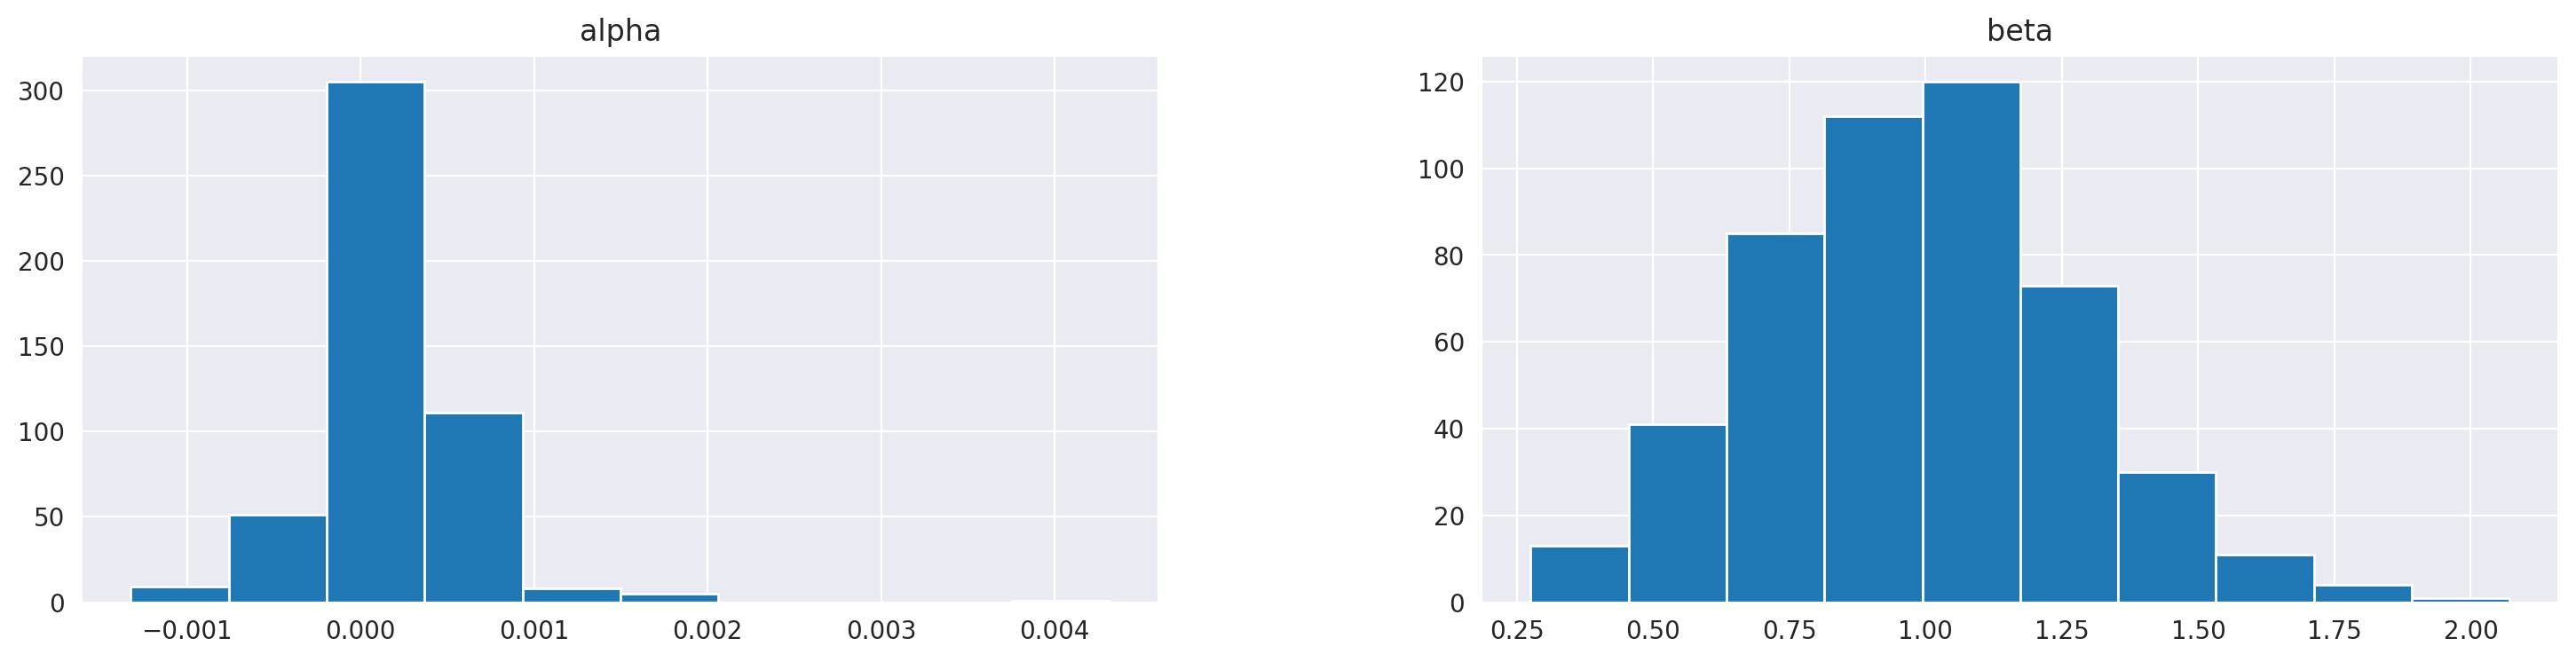

In [23]:
metrics_df[['alpha', 'beta']].hist(figsize=(18,4))

In [24]:
len(metrics_df[metrics_df['alpha_pval']>0.05]) / len(metrics_df)

0.9836734693877551

In [25]:
len(metrics_df[metrics_df['beta_pval']>0.05]) / len(metrics_df)

0.0

array([[<Axes: title={'center': 'R_sq'}>,
        <Axes: title={'center': 'Durbin-Watson'}>]], dtype=object)

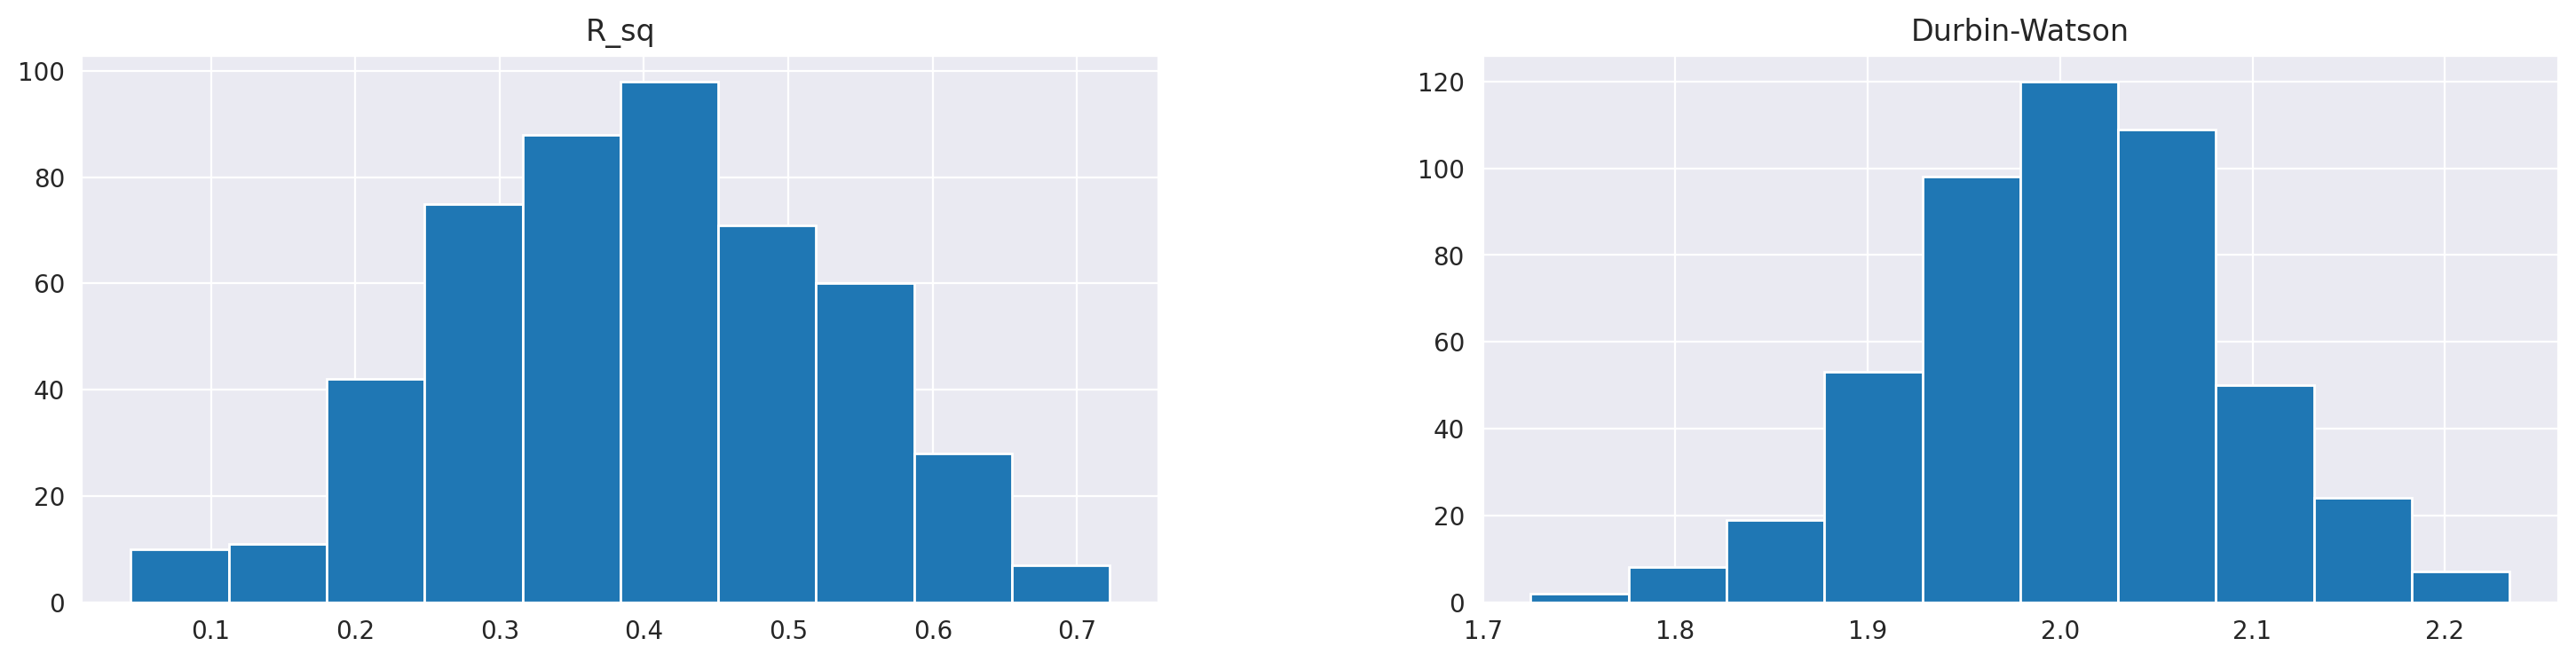

In [26]:
metrics_df[['R_sq', 'Durbin-Watson']].hist(figsize=(18,4))

In [27]:
from sklearn.linear_model import LinearRegression

positions = pd.DataFrame(index=returns_w.loc['2019-01-01':].index, columns=returns_w.columns)

target_vol = volatility_eqw
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    returns_rf_tmp = returns_rf.loc[returns_tmp.index]
    mkt_tmp = mkt_rf.loc[returns_tmp.index]
    
    # fit factor model
    res = LinearRegression().fit(mkt_tmp.values, returns_rf_tmp.values)
    betas = pd.DataFrame(res.coef_.flatten(), index=returns.columns, columns=['Beta'])
    
    # calculate covariance
    # use ddof in np.var and np.cov to account for a number of factors
    resid = returns_rf_tmp.values - res.predict(mkt_tmp.values) # residuals
    psi = np.diag(np.diag(np.cov(resid.T, ddof=2))) # residuals variance
    cov_factor = betas.values @ betas.values.T * mkt_tmp.values.var(ddof=1) + psi
    
    # perform optimization
    constraints = ({'type':'eq', 'fun': lambda x: volatility(x,cov_factor)-target_vol}, 
                   {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    res = minimize(negative_annual_return, x0, args=(returns_rf_tmp.mean()), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [19:29<00:00,  5.60s/it]


In [28]:
cumret_factor_cov_sim = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()
results_df.loc['MPT (factor cov - SIM)'] = calculate_metrics(cumret_factor_cov_sim)

In [29]:
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD,Volatility
SPY,0.619579,0.127457,0.675479,-0.318290,52.0,0.211137
Equally Weighted,0.933575,0.178278,0.799373,-0.367922,52.0,0.242669
MPT (sample cov),1.130718,0.207087,0.780375,-0.376376,59.0,0.301853
MPT (factor cov - SIM),1.554155,0.262771,0.829310,-0.391954,40.0,0.365052


# Fama-French

### 3-factor

In [30]:
factors_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=4, index_col=0).iloc[:-1]
factors_df.index = pd.to_datetime(factors_df.index)
factors_df = factors_df.loc[returns.index] # keep only relevant dates
factors_df /= 100 # percentage to decimal

In [31]:
factors_df

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-01-03,0.0059,-0.0039,-0.0018,0.00006
2018-01-04,0.0042,-0.0026,0.0024,0.00006
2018-01-05,0.0066,-0.0035,-0.0026,0.00006
2018-01-08,0.0019,-0.0015,0.0005,0.00006
2018-01-09,0.0015,-0.0035,-0.0004,0.00006
...,...,...,...,...
2022-12-23,0.0051,-0.0061,0.0116,0.00016
2022-12-27,-0.0051,-0.0074,0.0142,0.00016
2022-12-28,-0.0123,-0.0024,-0.0029,0.00016


In [32]:
metrics_df = pd.DataFrame(columns=['alpha', 'beta_1', 'beta_2', 'beta_3', 'alpha_pval', 'beta1_pval', 'beta2_pval', 'beta3_pval',  
                                   'R_sq', 'Durbin-Watson', 'JB pval'])

for stock in tqdm(returns_rf.columns):
    res = sm.OLS(returns_rf[stock].values, sm.add_constant(factors_df.iloc[:,:3].values)).fit() # fit a model
    metrics_df.loc[stock] = [*res.params, *res.pvalues, res.rsquared, sms.durbin_watson(res.resid), sms.jarque_bera(res.resid)[1]] # save metrics

100%|██████████| 490/490 [00:01<00:00, 284.73it/s]


In [33]:
metrics_df

,alpha,beta_1,beta_2,beta_3,alpha_pval,beta1_pval,beta2_pval,beta3_pval,R_sq,Durbin-Watson,JB pval
MMM,-0.000602,0.815084,-0.104154,0.361385,0.085142,2.918244e-166,3.879453e-02,7.508042e-29,0.475717,2.046503,0.000000e+00
AOS,-0.000147,0.820848,0.235106,0.250603,0.720634,1.391241e-130,7.965353e-05,2.757774e-11,0.407616,2.064497,1.570343e-247
ABT,0.000312,0.861155,-0.471142,-0.210779,0.338597,3.321014e-199,7.562139e-23,1.472074e-12,0.533000,1.991276,0.000000e+00
ABBV,0.000427,0.687245,-0.396716,0.069877,0.323391,8.632178e-91,2.528794e-10,7.387467e-02,0.280288,1.900517,0.000000e+00
ACN,0.000195,1.078037,-0.226542,-0.030293,0.484593,0.000000e+00,2.223901e-08,2.308009e-01,0.696803,2.101939,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.000221,0.787035,-0.178975,0.173983,0.531385,3.141618e-155,4.534781e-04,6.281050e-08,0.434184,2.057429,0.000000e+00
ZBRA,0.000546,1.246644,0.286384,-0.158556,0.295264,1.857802e-172,1.445247e-04,7.997227e-04,0.494462,2.152222,0.000000e+00
ZBH,-0.000090,0.889746,0.246058,0.263822,0.834377,1.405691e-139,7.020937e-05,1.498257e-11,0.427185,2.267317,0.000000e+00
ZION,-0.000014,1.061156,0.553801,1.190424,0.972347,4.829037e-206,6.361029e-22,8.670659e-177,0.677121,2.146827,0.000000e+00


In [34]:
metrics_df.describe()

,alpha,beta_1,beta_2,beta_3,alpha_pval,beta1_pval,beta2_pval,beta3_pval,R_sq,Durbin-Watson,JB pval
count,490.000000,490.000000,490.000000,490.000000,490.000000,4.900000e+02,4.900000e+02,4.900000e+02,490.000000,490.000000,4.900000e+02
mean,0.000203,0.988479,0.086817,0.265535,0.534206,1.498432e-17,1.116942e-01,3.679589e-02,0.468694,2.028875,7.835195e-37
std,0.000426,0.264006,0.388948,0.492605,0.270015,2.667603e-16,2.333994e-01,1.322208e-01,0.146079,0.083294,1.733964e-35
min,-0.001219,0.306500,-0.687812,-1.252173,0.000367,0.000000e+00,1.667341e-41,3.908145e-252,0.050954,1.695249,0.000000e+00
25%,-0.000017,0.811831,-0.203187,-0.046602,0.329539,2.572349e-202,7.748538e-12,1.457330e-47,0.372070,1.976481,0.000000e+00
50%,0.000199,0.983436,0.022844,0.253736,0.536867,3.438053e-149,1.682164e-05,4.141452e-18,0.471618,2.030147,0.000000e+00
75%,0.000382,1.166507,0.337574,0.599289,0.742740,2.713998e-109,7.302506e-02,3.223814e-05,0.563731,2.079636,0.000000e+00
max,0.004428,1.969524,1.621192,1.579733,0.999825,5.665313e-15,9.974432e-01,9.569293e-01,0.814614,2.267317,3.838294e-34


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

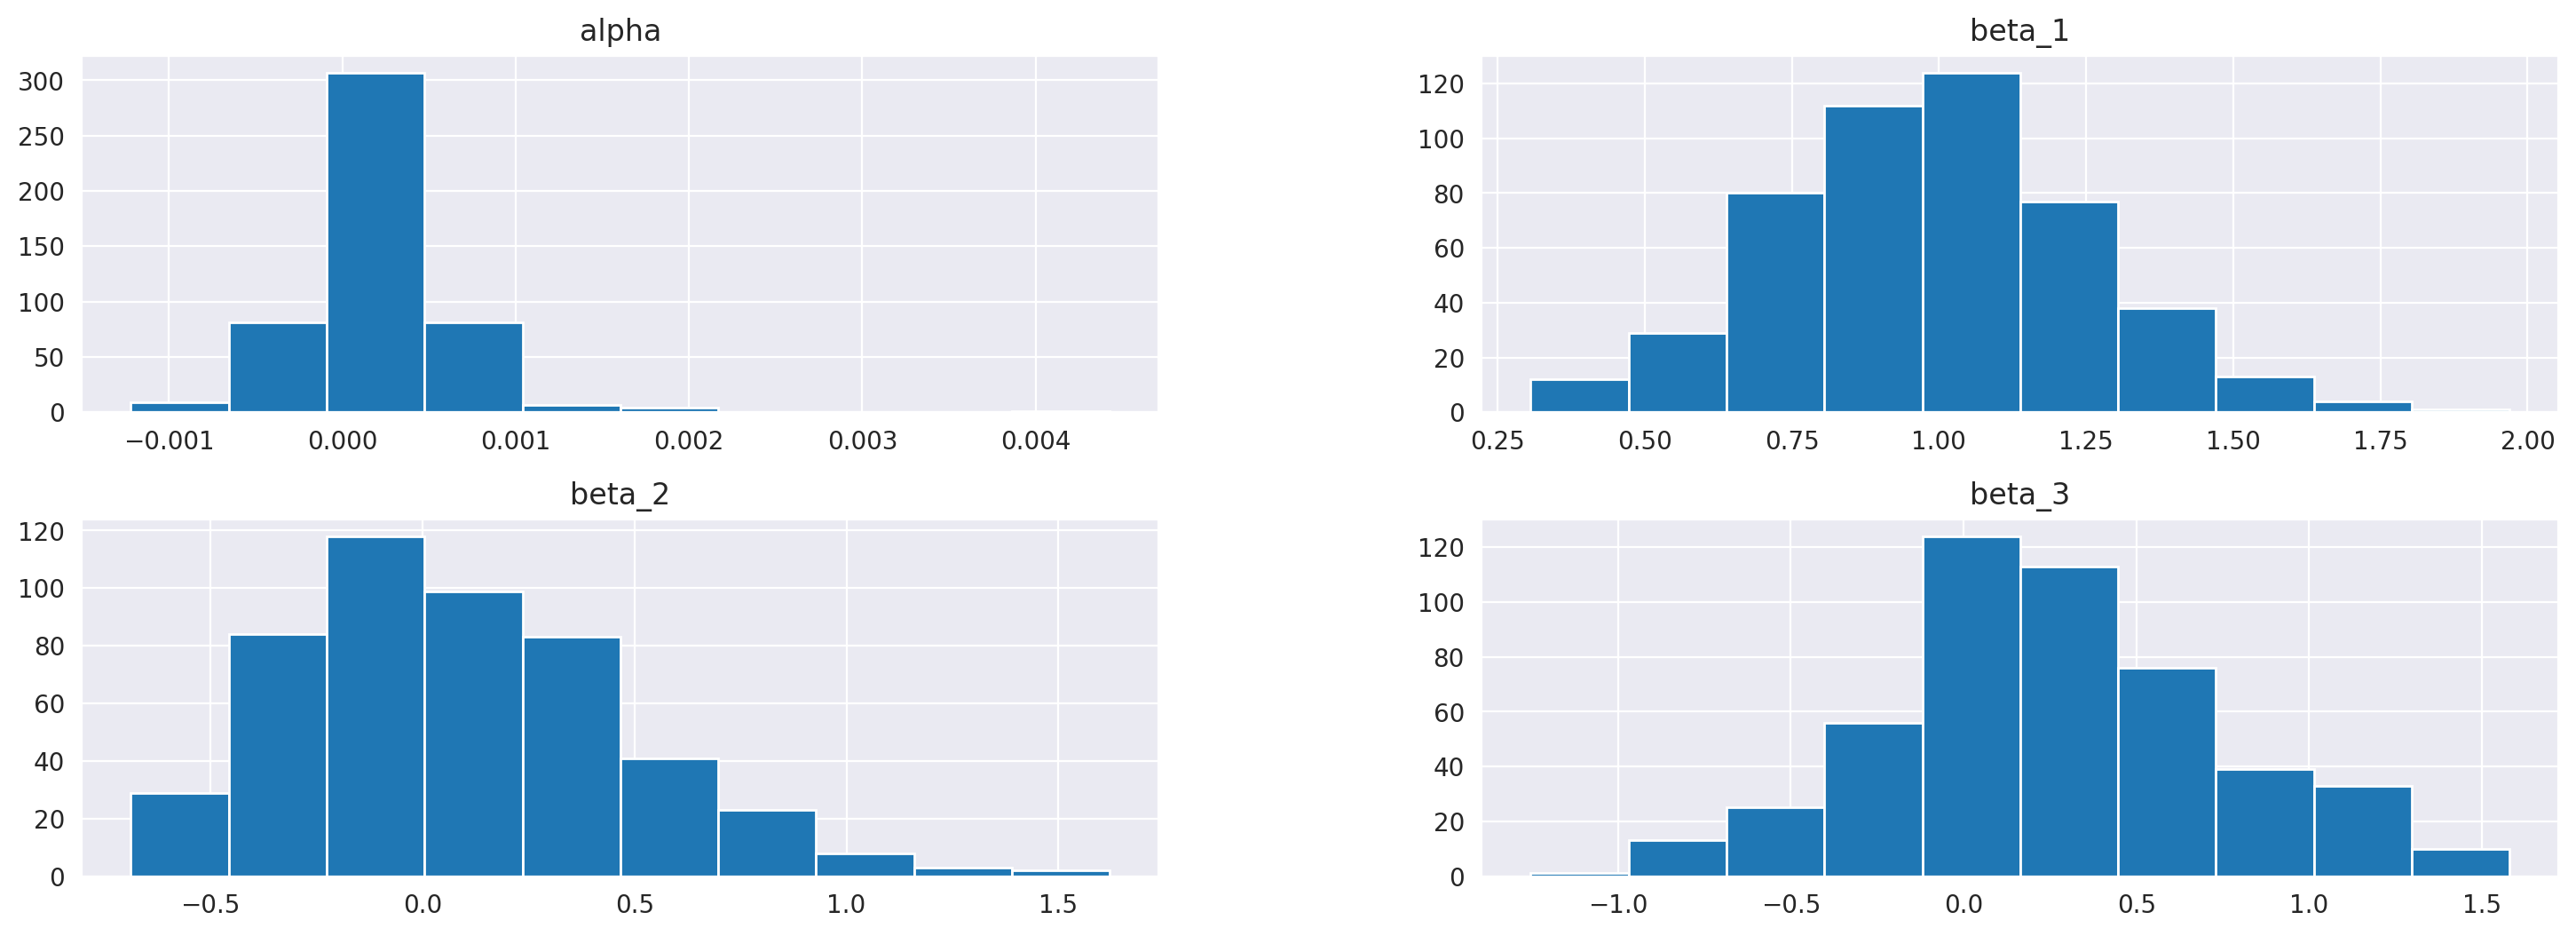

In [35]:
metrics_df[['alpha', 'beta_1', 'beta_2', 'beta_3']].hist(figsize=(18,6))

In [36]:
len(metrics_df[metrics_df['alpha_pval']>0.05]) / len(metrics_df)

0.9734693877551021

In [37]:
len(metrics_df[metrics_df['beta1_pval']>0.05]) / len(metrics_df)

0.0

In [38]:
len(metrics_df[metrics_df['beta2_pval']>0.05]) / len(metrics_df)

0.2653061224489796

In [39]:
len(metrics_df[metrics_df['beta3_pval']>0.05]) / len(metrics_df)

0.10612244897959183

array([[<Axes: title={'center': 'R_sq'}>,
        <Axes: title={'center': 'Durbin-Watson'}>]], dtype=object)

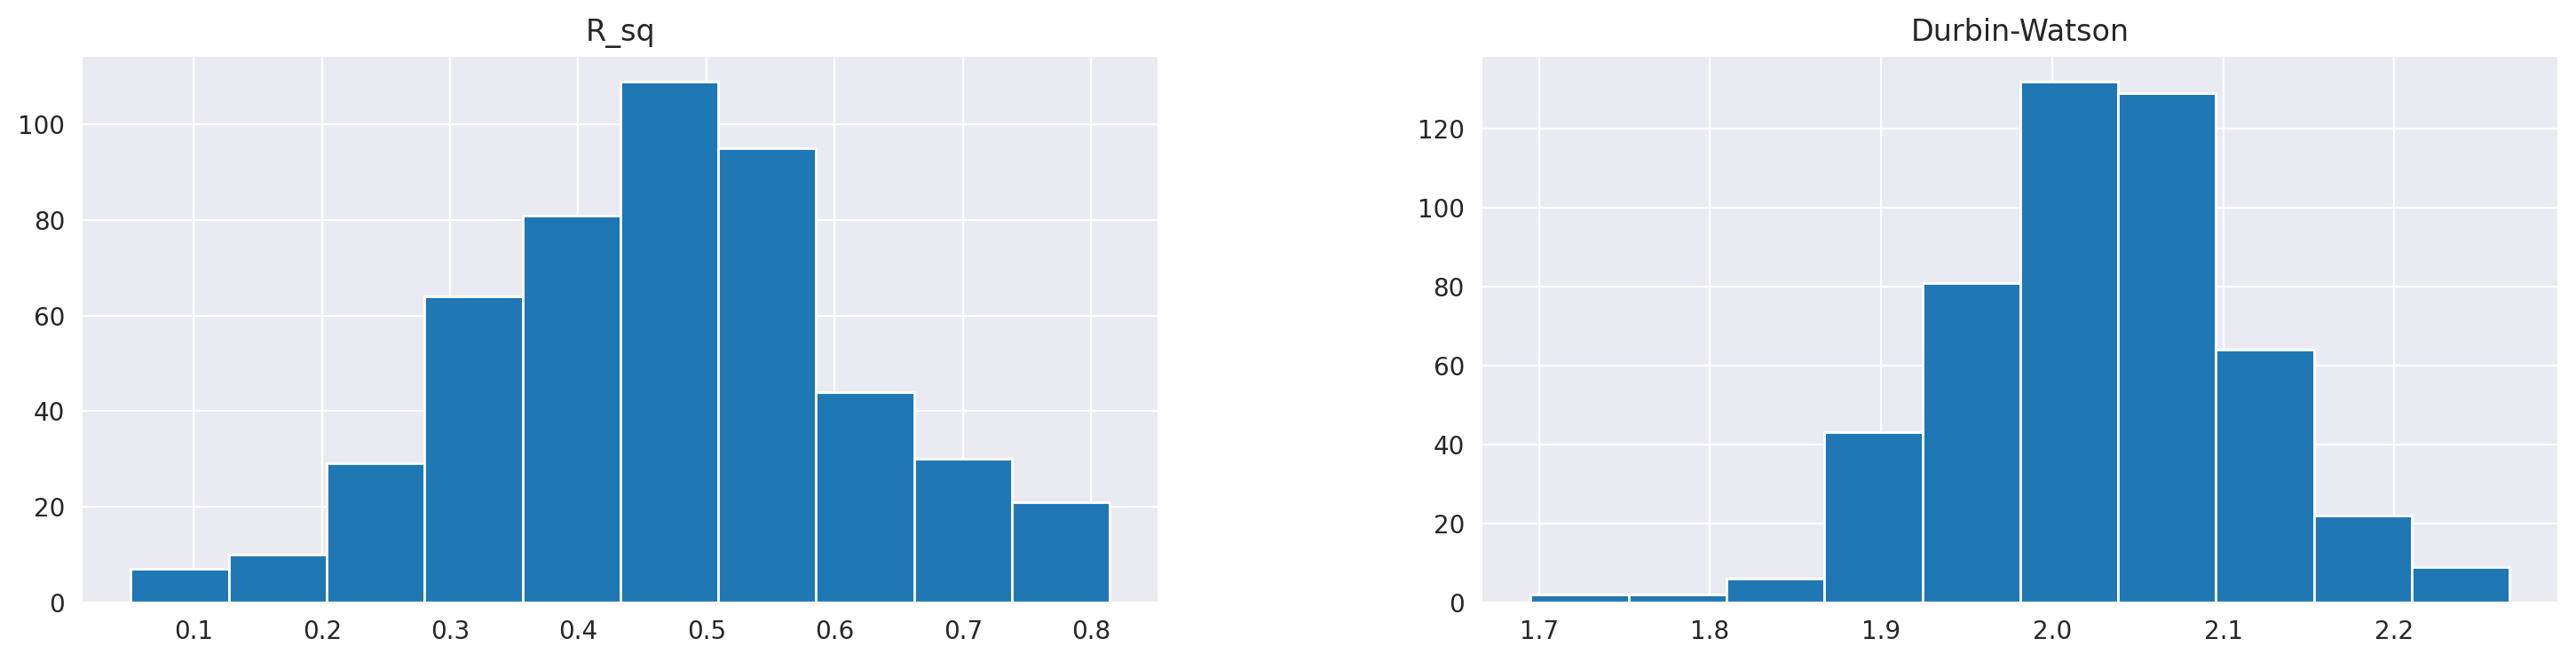

In [40]:
metrics_df[['R_sq', 'Durbin-Watson']].hist(figsize=(18,4))

In [41]:
positions = pd.DataFrame(index=returns_w.loc['2019-01-01':].index, columns=returns_w.columns)

target_vol = volatility_eqw
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

K = 3 # number of factors

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    factors_tmp = factors_df.loc[returns_tmp.index]
    returns_rf_tmp = returns_rf.loc[returns_tmp.index]
    
    # fit factor model
    res = LinearRegression().fit(factors_tmp.iloc[:,:3].values, returns_rf_tmp.values)
    B = res.coef_
    # estimate covariance and other parameters
    omega_f = factors_tmp.iloc[:,:3].cov() # covariance of the factors
    resid = returns_rf_tmp.values - res.predict(factors_tmp.iloc[:,:3].values) # model residuals
    psi = np.diag(np.diag(np.cov(resid.T, ddof=K+1))) # residuals variance
    cov_factor = B @ omega_f.values @ B.T + psi # covariance of asset returns
    
    # perform optimization
    constraints = ({'type':'eq', 'fun': lambda x: volatility(x,cov_factor)-target_vol}, 
                   {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    res = minimize(negative_annual_return, x0, args=(returns_rf_tmp.mean()), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [19:23<00:00,  5.57s/it]


In [42]:
cumret_factor_cov_ff3 = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()
results_df.loc['MPT (factor cov - FF3)'] = calculate_metrics(cumret_factor_cov_ff3)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD,Volatility
SPY,0.619579,0.127457,0.675479,-0.318290,52.0,0.211137
Equally Weighted,0.933575,0.178278,0.799373,-0.367922,52.0,0.242669
MPT (sample cov),1.130718,0.207087,0.780375,-0.376376,59.0,0.301853
MPT (factor cov - SIM),1.554155,0.262771,0.829310,-0.391954,40.0,0.365052
MPT (factor cov - FF3),1.091910,0.201579,0.730521,-0.389626,31.0,0.328383


### 5 factor

In [43]:
factors_df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3, index_col=0).iloc[:-1]
factors_df.index = pd.to_datetime(factors_df.index.map(str))
factors_df = factors_df.loc[returns.index]
factors_df /= 100 # percentage to decimal

In [44]:
factors_df

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2018-01-03,0.0059,-0.0046,-0.0018,-0.0070,-0.0006,0.00006
2018-01-04,0.0042,-0.0022,0.0024,-0.0002,0.0031,0.00006
2018-01-05,0.0066,-0.0037,-0.0026,0.0037,-0.0038,0.00006
2018-01-08,0.0019,-0.0019,0.0005,-0.0007,0.0001,0.00006
2018-01-09,0.0015,-0.0039,-0.0004,-0.0013,0.0003,0.00006
...,...,...,...,...,...,...
2022-12-23,0.0051,-0.0034,0.0116,0.0086,0.0046,0.00016
2022-12-27,-0.0051,-0.0044,0.0142,0.0116,0.0122,0.00016
2022-12-28,-0.0123,-0.0030,-0.0029,-0.0096,-0.0004,0.00016


In [45]:
metrics_df = pd.DataFrame(columns=['alpha', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5', 'alpha_pval', 
                                   'beta1_pval', 'beta2_pval', 'beta3_pval', 'beta4_pval', 'beta5_pval', 
                                   'R_sq', 'Durbin-Watson', 'JB pval'])

for stock in tqdm(returns_rf.columns):
    res = sm.OLS(returns_rf[stock].values, sm.add_constant(factors_df.iloc[:,:5].values)).fit() # fit a model
    metrics_df.loc[stock] = [*res.params, *res.pvalues, res.rsquared, sms.durbin_watson(res.resid), sms.jarque_bera(res.resid)[1]] # save metrics

100%|██████████| 490/490 [00:01<00:00, 261.82it/s]


In [46]:
metrics_df

,alpha,beta_1,beta_2,beta_3,beta_4,beta_5,alpha_pval,beta1_pval,beta2_pval,beta3_pval,beta4_pval,beta5_pval,R_sq,Durbin-Watson,JB pval
MMM,-0.000795,0.853564,0.120682,0.115685,0.531612,0.339420,0.019657,1.519910e-170,2.283180e-02,1.287773e-02,3.734919e-15,1.648458e-04,0.506767,2.007205,0.0
AOS,-0.000275,0.817599,0.459683,0.025781,0.698838,-0.105083,0.492992,1.990008e-124,2.962024e-13,6.372886e-01,2.009480e-18,3.203790e-01,0.445162,2.071909,0.0
ABT,0.000233,0.899649,-0.431192,-0.222238,-0.036440,0.379256,0.474322,1.382216e-196,4.341514e-17,6.246179e-07,5.677908e-01,1.069325e-05,0.538933,1.998471,0.0
ABBV,0.000340,0.718097,-0.301661,0.024749,0.069267,0.319773,0.432651,1.527903e-88,8.361868e-06,6.756452e-01,4.152678e-01,5.248264e-03,0.280896,1.899104,0.0
ACN,0.000189,1.067164,-0.173441,0.011312,0.194861,-0.164579,0.497110,1.597015e-300,6.810000e-05,7.663914e-01,3.827982e-04,2.554740e-02,0.699984,2.112815,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.000190,0.778509,-0.068678,0.161870,0.269182,-0.114070,0.590615,2.475462e-140,2.116258e-01,8.082072e-04,1.075244e-04,2.212636e-01,0.439003,2.058554,0.0
ZBRA,0.000527,1.229999,0.351430,-0.241490,0.303755,-0.206142,0.312103,1.061307e-155,1.591236e-05,7.096038e-04,3.030340e-03,1.342940e-01,0.498724,2.154990,0.0
ZBH,-0.000028,0.852939,0.288222,0.280659,0.075571,-0.321599,0.947590,3.208881e-120,1.552037e-05,1.642427e-06,3.671036e-01,4.390399e-03,0.434771,2.270428,0.0
ZION,0.000258,0.966707,0.384919,1.437943,-0.314252,-0.876357,0.494059,1.363823e-175,8.535096e-11,1.700752e-133,2.401377e-05,4.917641e-18,0.702365,2.144303,0.0


In [47]:
metrics_df.describe().applymap(lambda x: f'{x:0.4f}')

,alpha,beta_1,beta_2,beta_3,beta_4,beta_5,alpha_pval,beta1_pval,beta2_pval,beta3_pval,beta4_pval,beta5_pval,R_sq,Durbin-Watson,JB pval
count,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000,490.0000
mean,0.0002,0.9835,0.1297,0.2292,0.0844,-0.0347,0.5494,0.0000,0.1091,0.0689,0.1593,0.1785,0.4818,2.0329,0.0000
std,0.0005,0.2306,0.3612,0.5215,0.3438,0.4822,0.2838,0.0000,0.2283,0.1890,0.2636,0.2819,0.1436,0.0821,0.0000
min,-0.0010,0.4082,-0.4818,-1.0543,-1.4044,-1.8201,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0797,1.6685,0.0000
25%,-0.0000,0.8208,-0.1510,-0.1435,-0.0568,-0.3122,0.3165,0.0000,0.0000,0.0000,0.0000,0.0000,0.3825,1.9826,0.0000
50%,0.0001,0.9739,0.0665,0.1540,0.1433,-0.0097,0.5622,0.0000,0.0002,0.0000,0.0044,0.0090,0.4803,2.0340,0.0000
75%,0.0004,1.1277,0.3600,0.4954,0.2999,0.2922,0.7988,0.0000,0.0476,0.0056,0.2359,0.2661,0.5758,2.0809,0.0000
max,0.0047,1.7751,1.4318,1.7955,0.8426,1.3919,0.9990,0.0000,0.9960,0.9725,0.9913,0.9992,0.8315,2.2704,0.0000


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'beta_4'}>,
        <Axes: title={'center': 'beta_5'}>]], dtype=object)

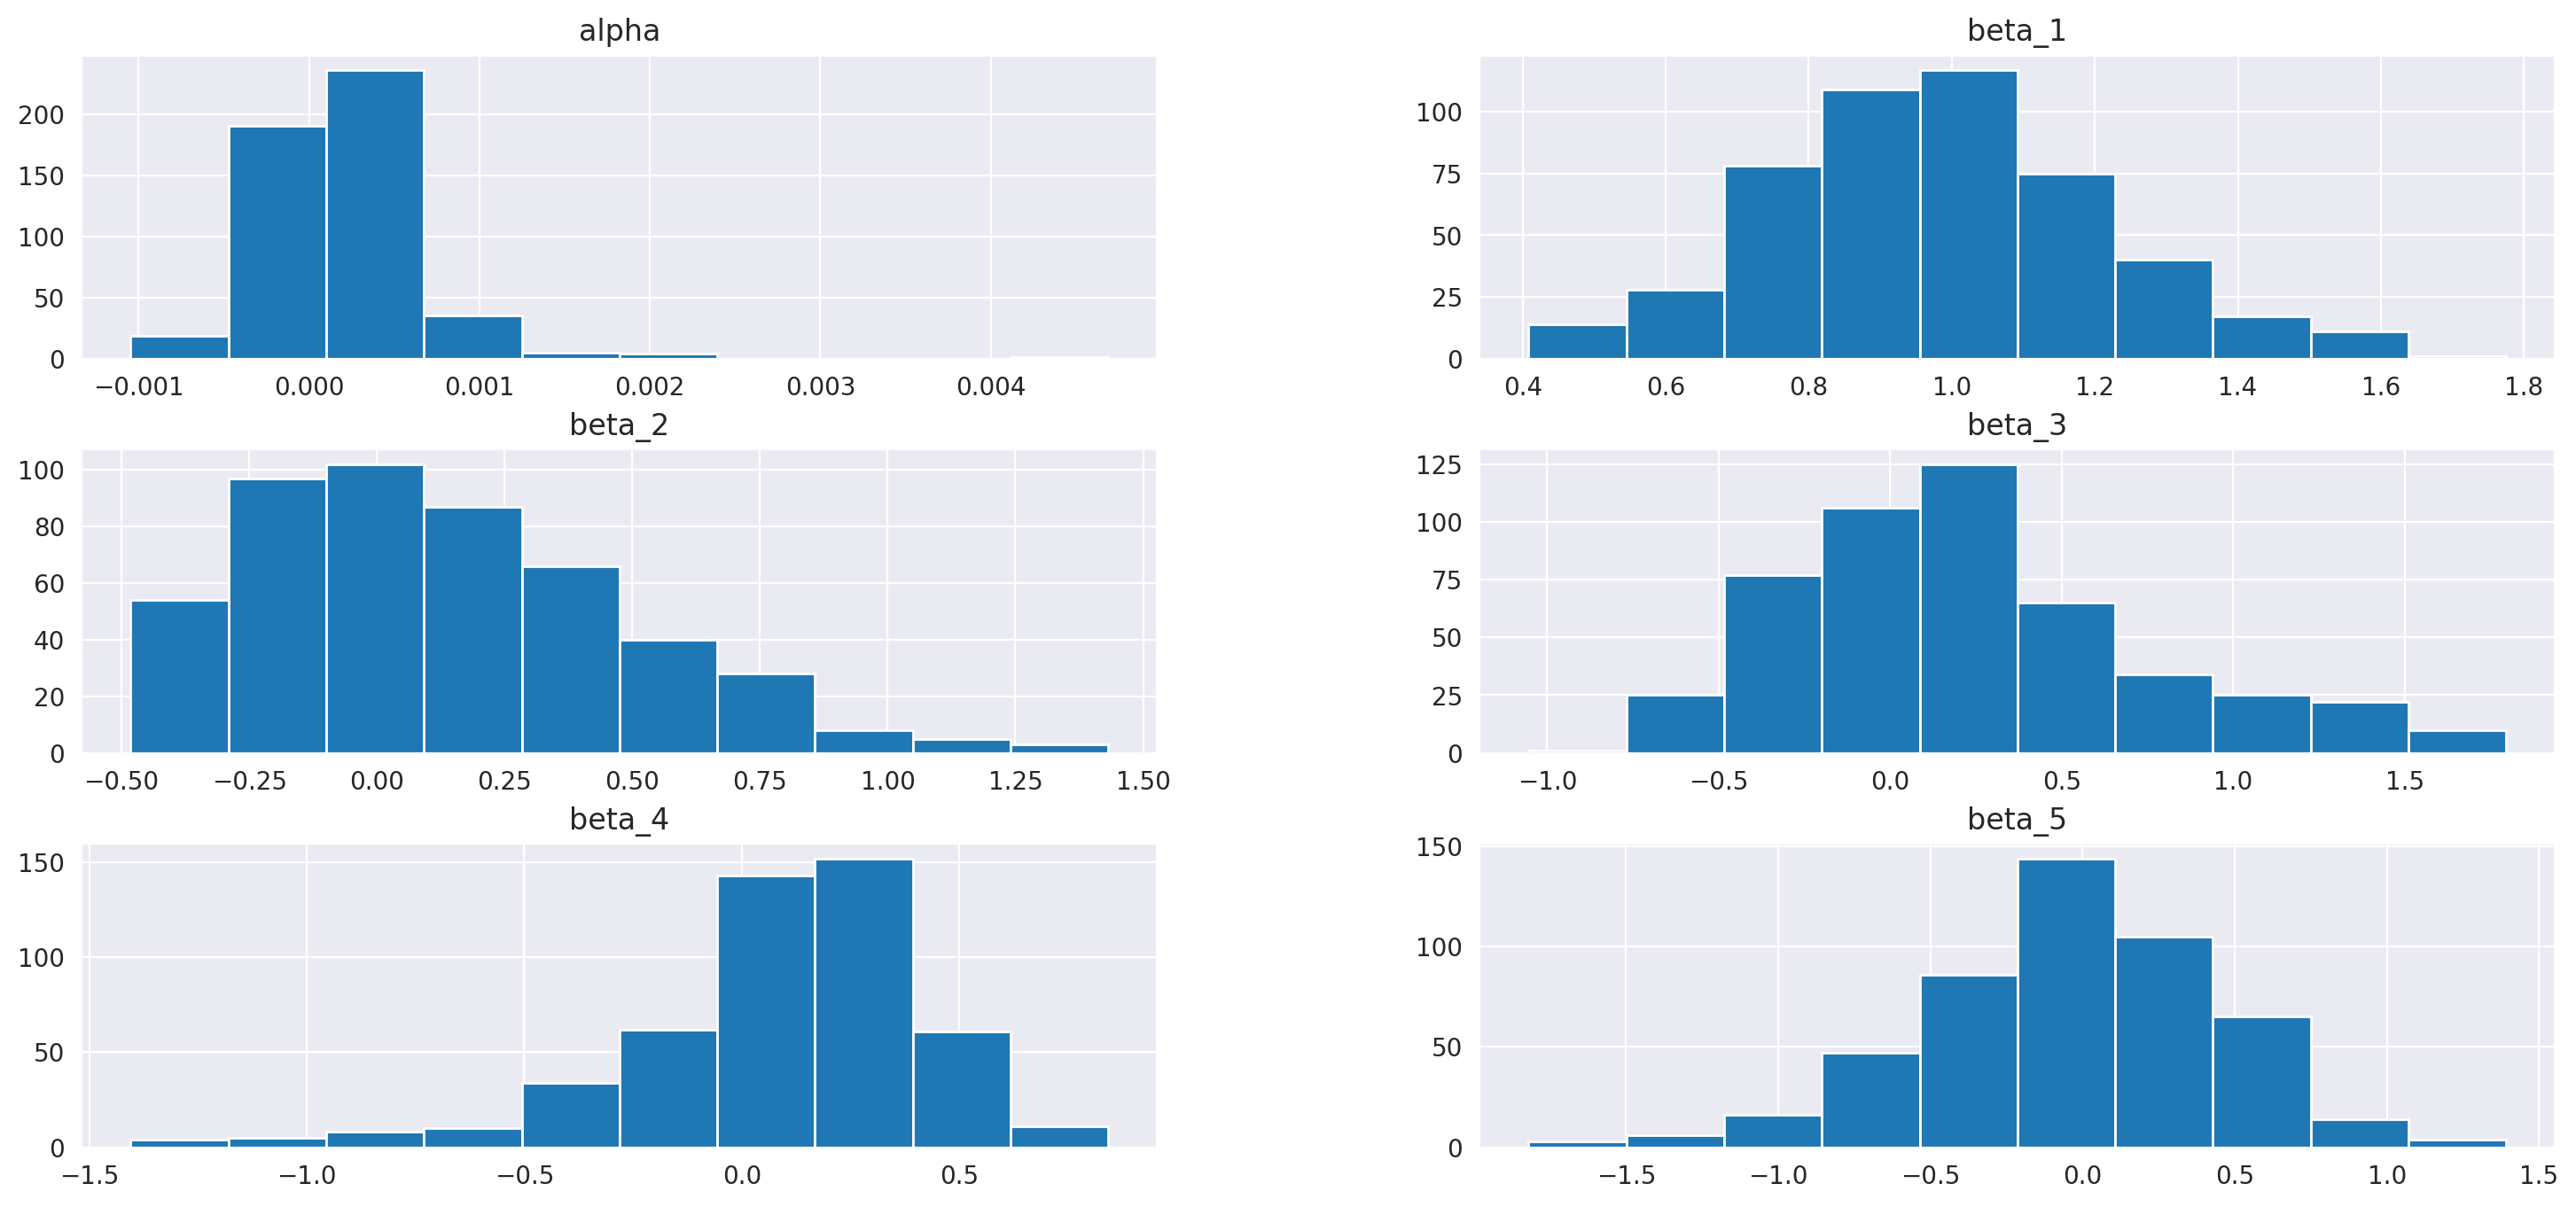

In [48]:
metrics_df[['alpha', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5']].hist(figsize=(18,8))

In [49]:
len(metrics_df[metrics_df['alpha_pval']>0.05]) / len(metrics_df)

0.9591836734693877

In [50]:
len(metrics_df[metrics_df['beta1_pval']>0.05]) / len(metrics_df)

0.0

In [51]:
len(metrics_df[metrics_df['beta2_pval']>0.05]) / len(metrics_df)

0.24693877551020407

In [52]:
len(metrics_df[metrics_df['beta3_pval']>0.05]) / len(metrics_df)

0.17142857142857143

In [53]:
len(metrics_df[metrics_df['beta4_pval']>0.05]) / len(metrics_df)

0.36122448979591837

In [54]:
len(metrics_df[metrics_df['beta5_pval']>0.05]) / len(metrics_df)

0.41020408163265304

array([[<Axes: title={'center': 'R_sq'}>,
        <Axes: title={'center': 'Durbin-Watson'}>]], dtype=object)

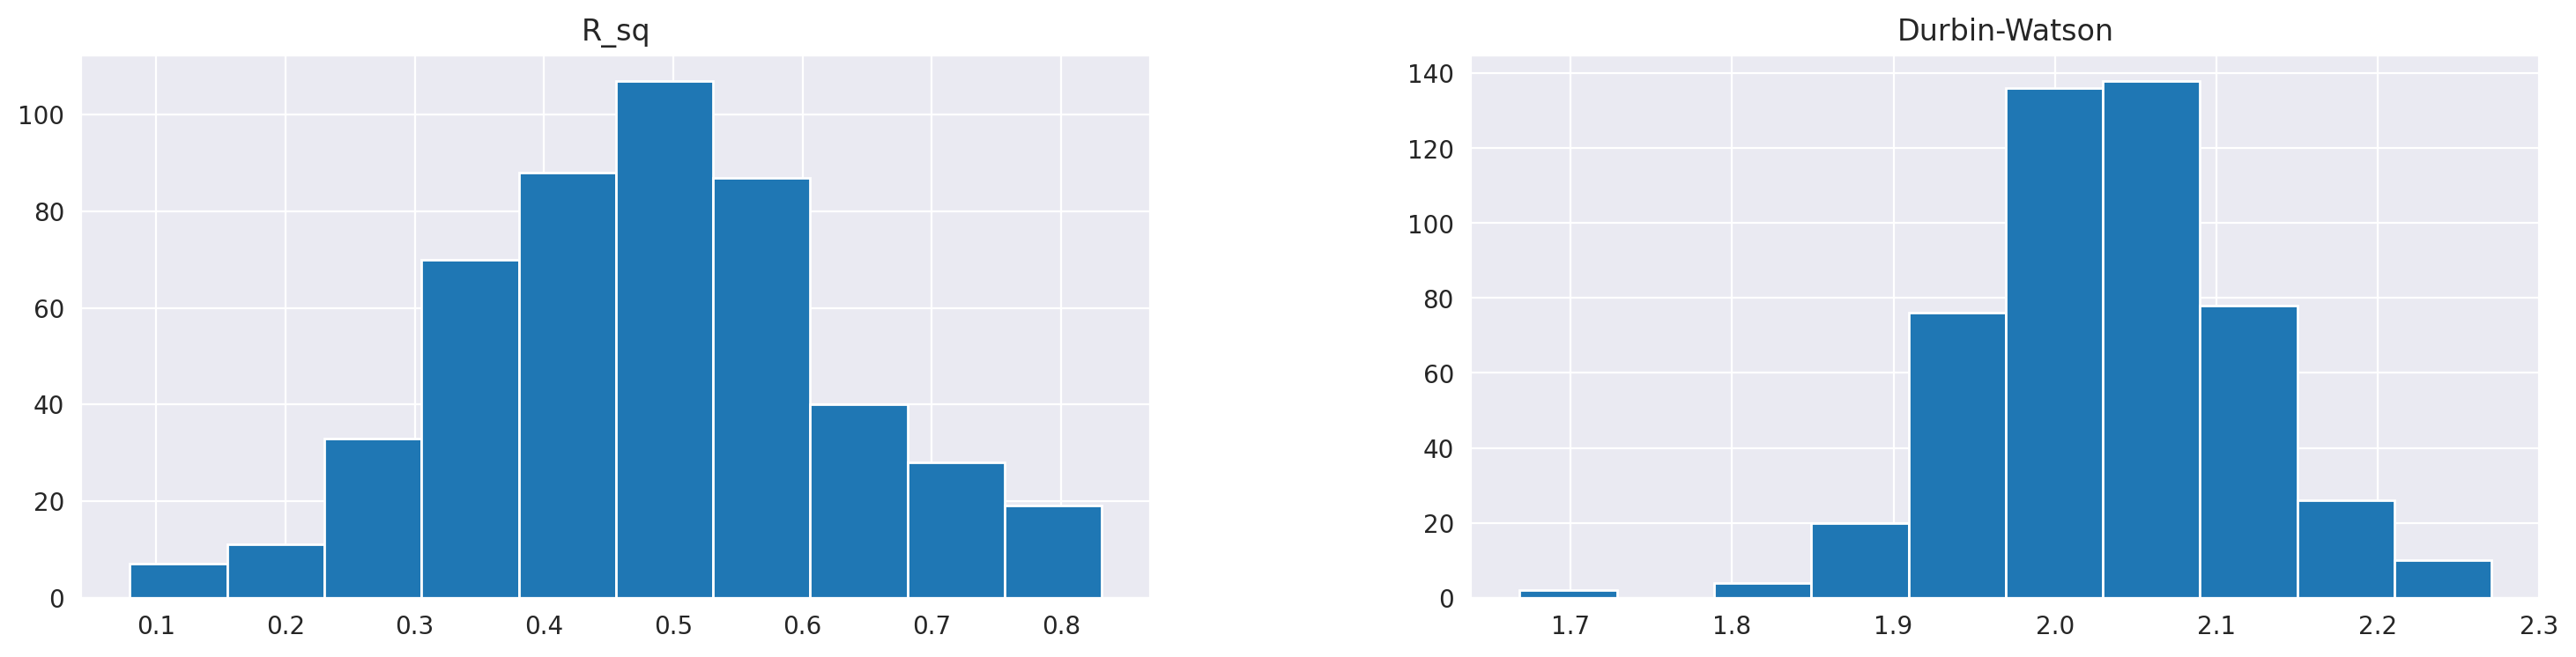

In [55]:
metrics_df[['R_sq', 'Durbin-Watson']].hist(figsize=(18,4))

In [56]:
positions = pd.DataFrame(index=returns_w.loc['2019-01-01':].index, columns=returns_w.columns)

target_vol = volatility_eqw
bounds=[[0,1]]*len(stocks)
x0 = np.ones(len(stocks)) / len(stocks)

K = 5 # number of factors

for t in tqdm(returns_w.loc['2019-01-01':].index):
    # prepare data
    prices_tmp = prices.loc[:t].iloc[-252:]
    returns_tmp = prices_tmp.pct_change().dropna()
    factors_tmp = factors_df.loc[returns_tmp.index]
    returns_rf_tmp = returns_rf.loc[returns_tmp.index]
    
    # fit factor model
    res = LinearRegression().fit(factors_tmp.iloc[:,:5].values, returns_rf_tmp.values)
    B = res.coef_
    # estimate covariance and other parameters
    omega_f = factors_tmp.iloc[:,:5].cov() # covariance of the factors
    resid = returns_rf_tmp.values - res.predict(factors_tmp.iloc[:,:5].values) # model residuals
    psi = np.diag(np.diag(np.cov(resid.T, ddof=K+1))) # residuals variance
    cov_factor = B @ omega_f.values @ B.T + psi # covariance of asset returns
    
    # perform optimization
    constraints = ({'type':'eq', 'fun': lambda x: volatility(x,cov_factor)-target_vol}, 
                   {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    res = minimize(negative_annual_return, x0, args=(returns_rf_tmp.mean()), 
               bounds=bounds, constraints=constraints)
    if res.status!=0:
        print('Optimization failed')
        positions.loc[t] = positions.loc[:t].iloc[-2] # keep previous weights
    else:
        positions.loc[t] = res.x

100%|██████████| 209/209 [19:42<00:00,  5.66s/it]


In [57]:
cumret_factor_cov_ff5 = (1 + (positions.shift() * returns_w.loc['2019-01-01':]).sum(axis=1)).cumprod()
results_df.loc['MPT (factor cov - FF5)'] = calculate_metrics(cumret_factor_cov_ff5)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD,Volatility
SPY,0.619579,0.127457,0.675479,-0.318290,52.0,0.211137
Equally Weighted,0.933575,0.178278,0.799373,-0.367922,52.0,0.242669
MPT (sample cov),1.130718,0.207087,0.780375,-0.376376,59.0,0.301853
MPT (factor cov - SIM),1.554155,0.262771,0.829310,-0.391954,40.0,0.365052
MPT (factor cov - FF3),1.091910,0.201579,0.730521,-0.389626,31.0,0.328383
MPT (factor cov - FF5),1.024371,0.191808,0.713782,-0.390298,40.0,0.321183


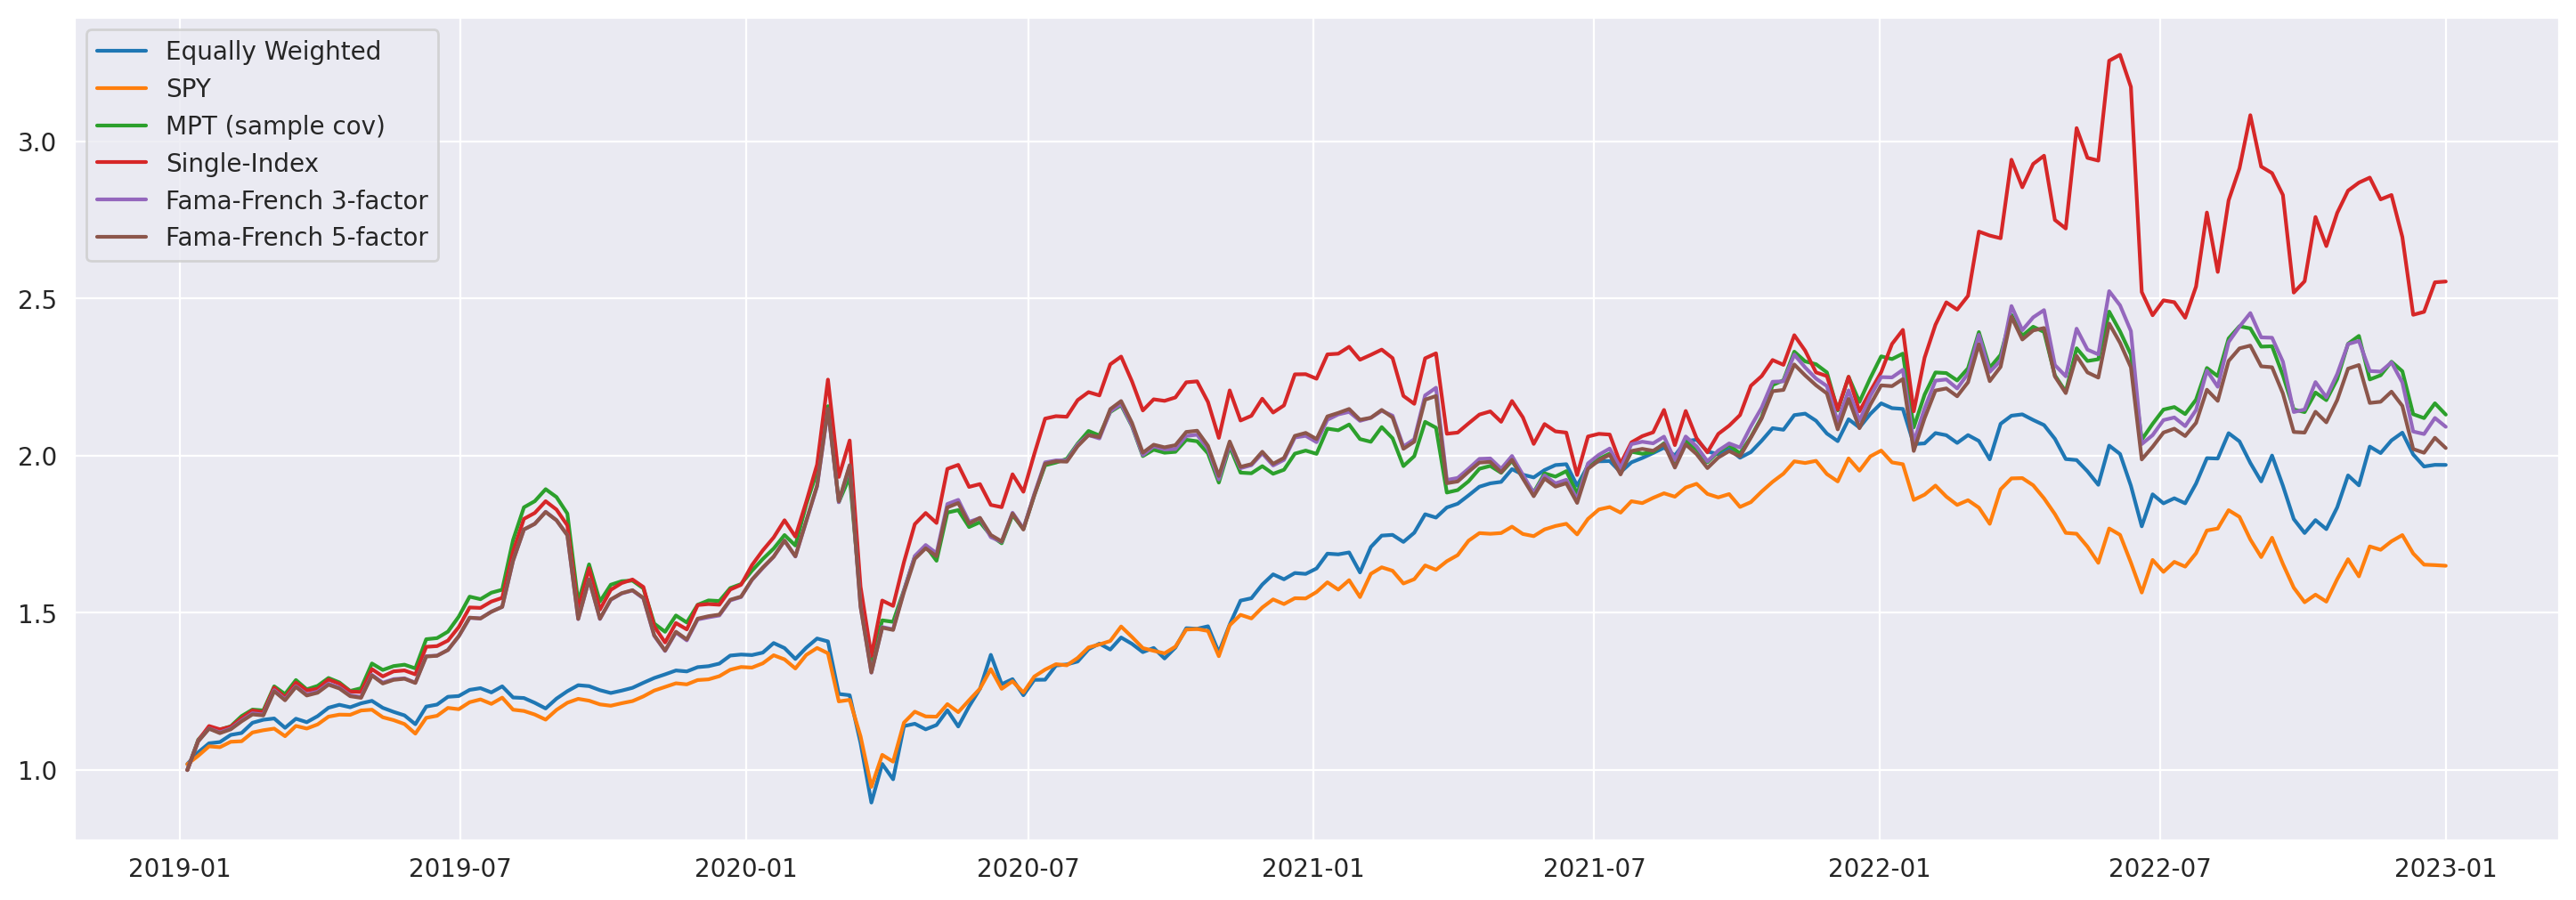

In [59]:
plt.figure(figsize=(18,6))
plt.plot(cumret_eqw, label='Equally Weighted')
plt.plot(cumret_spy, label='SPY')
plt.plot(cumret_sample_cov, label='MPT (sample cov)')
plt.plot(cumret_factor_cov_sim, label='Single-Index')
plt.plot(cumret_factor_cov_ff3, label='Fama-French 3-factor')
plt.plot(cumret_factor_cov_ff5, label='Fama-French 5-factor')
plt.legend()